# OLS on Basic Variable Set

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
#from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
from reed import *
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time
import statsmodels.api as sm
from direct_regression import plot_ate_distribution


# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

#### Select modeling parameters

In [2]:
outcome = 'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
config_name = "default"
data_file = "data/basic_variables.csv"
test = False

In [3]:
# Parameters
test = False
outcome = "y_wsce"
treatment = "redufl"


In [4]:
# parameters that depend on those set above (which may have been inserted by Papermill)
if test:
    inner_cv = 2
    outer_cv = 2
    bootstrap_samples = 3

else:
    inner_cv = 5
    outer_cv = 10
    bootstrap_samples = 1000

### Load Data 
   - drop rows missing the specified treatment or outcome

Dropped 284 rows missing treatment or outcome.


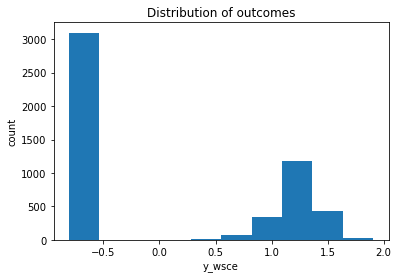

In [5]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    shift = 1 - data[outcome].min() # to ensure log is defined
    data[outcome] = np.log(data[outcome]+shift)
if standardize_outcome:
    mu, std = data[outcome].mean(), data[outcome].std()
    data[outcome] = (data[outcome]-mu)/std
    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [6]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 21)
Treated data dimensions: (1368, 21)


### Compute unconditional/unadjusted estimate of treatment effect

In [7]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [8]:
from sklearn.linear_model import LinearRegression
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

In [9]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    None,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=False)

Fitting OLS ...Done


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
OLS,0.07,0.01,0.40,0.04,0.23,0.10,-0.55,0.04,-0.78,0.10


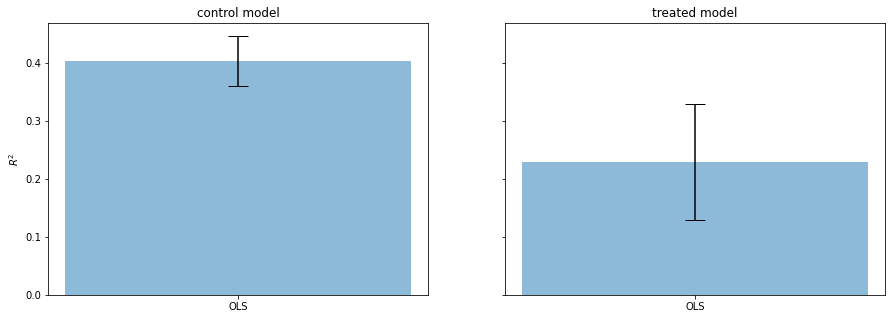

In [10]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models

In [11]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

OLS


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
"ahgage_(54, 120]",0.599575,0.011354,-0.089211,0.013726,-0.644180,0.015401,-0.554969,0.010715
"ahgage_(44, 54]",0.488677,0.007702,0.031795,0.020707,-0.472780,0.015092,-0.504574,0.010259
aesdtl_3.0,0.193353,0.013221,-0.064092,0.024929,-0.225399,0.024190,-0.161307,0.008670
"ahgage_(34, 44]",0.108405,0.006812,-0.086892,0.018637,-0.151851,0.010774,-0.064959,0.012263
aedhigh1_9.0,0.091880,0.009129,-0.055360,0.027072,-0.119560,0.021579,-0.064200,0.008212
aesdtl_2.0,0.057491,0.010480,0.007438,0.020781,-0.053773,0.018852,-0.061210,0.008954
interact_ahgsex_2.0_aesdtl_3.0,0.051315,0.013508,0.097335,0.026105,0.093650,0.024943,-0.003685,0.013202
interact_ahgsex_2.0_aesdtl_2.0,0.042050,0.010182,0.021036,0.026818,0.052568,0.020411,0.031532,0.012262
aedhigh1_8.0,0.036151,0.006632,-0.049347,0.016323,-0.059725,0.011857,-0.010378,0.009628


### What are the major confounders

  - We want to identify variables that strongly effect both treatment and outcome
   
For each variable Z, in the covariate set lets compute $E[Z|T=1] - E[Z|T=0]$

In [12]:
Xt = np.hstack((t.reshape(-1,1),X))
model = LinearRegression()
model.fit(Xt,y)
beta = model.coef_[1:]

confound = pd.DataFrame({'response_coef':beta, 'treatment_inf':X1.mean(axis=0) - X0.mean(axis=0)},index=features)
confound['confound'] = np.abs(confound['response_coef'])*np.abs(confound['treatment_inf'])
confound.sort_values(by='confound',ascending=False)

,response_coef,treatment_inf,confound
"ahgage_(54, 120]",-0.566253,-0.574540,0.325335
"ahgage_(44, 54]",-0.500709,-0.116053,0.058109
aesdtl_3.0,-0.171150,-0.291709,0.049926
"ahgage_(34, 44]",-0.093023,0.252289,0.023469
aedhigh1_9.0,-0.072143,-0.283646,0.020463
"interact_ahgsex_2.0_ahgage_(54, 120]",0.034004,-0.405574,0.013791
"interact_ahgsex_2.0_ahgage_(34, 44]",-0.030138,0.261578,0.007883
aesdtl_2.0,-0.059739,0.091144,0.005445
interact_ahgsex_2.0_aesdtl_2.0,0.040198,0.135050,0.005429
interact_ahgsex_2.0_aesdtl_3.0,0.019562,-0.177558,0.003473


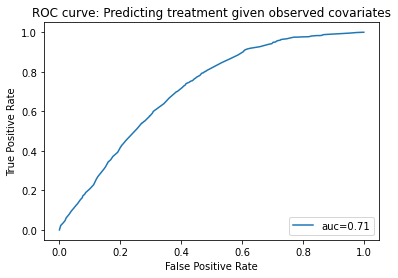

In [13]:
p_model = LogisticRegression()
p_model.fit(X,t)
p_model.coef_
p = p_model.predict_proba(X)[:,1]
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(t,p)
fpr, tpr, _ = roc_curve(t,p)
plt.plot(fpr, tpr,label=f'auc={auc:.2f}')
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: Predicting treatment given observed covariates");

In [14]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    construct_models,
    None,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=inner_cv,
    load_from_cache=False,
    samples=bootstrap_samples
)

Fitting OLS ...

Done
Total time:2.7995450496673584 seconds


####  Average treatment effect uncertainty via Bootstrapping

,ACE,ACE_std
OLS,0.070909,0.027924


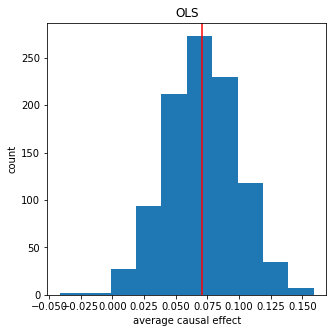

In [15]:
from direct_regression import compute_ate

metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
display(metrics)
plot_ate_distribution(tau_estimatesb)

## Statsmodels

Statsmodels provides a useful comparison, in that it is an independent implementation of OLS and provides theory based confidence intervals and p-values.

### Control Model

In [16]:
x0 = sm.add_constant(X0)
x0 = pd.DataFrame(x0, columns=['intercept']+features)
model0 = sm.OLS(y0,x0)
sm_result = model0.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     126.2
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:00:40   Log-Likelihood:                -4217.0
No. Observations:                3789   AIC:                             8478.
Df Residuals:                    3767   BIC:                             8615.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                               -0.0306      0.012     -2.499      0.012      -0.055      -0.007
ahgage_(34, 44]                         -0.0649      0.024     -2.653      0.008      -0.113      -0.017
ahgage_(44, 54]                         -0.5045      0.024    -21.140      0.000      -0.551      -0.458
ahgage_(54, 120]                        -0.5550      0.025    -22.226      0.000      -0.604      -0.506
ahgsex_2.0                              -0.0295      0.049     -0.607      0.544      -0.125       0.066
aedhigh1_3.0                             0.0104      0.024      0.426      0.670      -0.038       0.058
aedhigh1_4.0                            -0.0154      0.023     -0.671      0.502      -0.060       0.030
aedhigh1_5.0                            -0.0109      0.025     -0.444      0.657      -0.059       0.037
aedhigh1_8.0                            -0.0104      0.026     -0.404      0.687      -0.061       0.040
aedhigh1_9.0                            -0.0643      0.031     -2.092      0.036      -0.124      -0.004
aesdtl_2.0                              -0.0611      0.026     -2.370      0.018      -0.112      -0.011
aesdtl_3.0                              -0.1613      0.023     -7.087      0.000      -0.206      -0.117
interact_ahgsex_2.0_ahgage_(34, 44]     -0.0378      0.027     -1.396      0.163      -0.091       0.015
interact_ahgsex_2.0_ahgage_(44, 54]      0.0361      0.026      1.393      0.164      -0.015       0.087
interact_ahgsex_2.0_ahgage_(54, 120]     0.0442      0.027      1.658      0.097      -0.008       0.097
interact_ahgsex_2.0_aedhigh1_3.0         0.0156      0.026      0.592      0.554      -0.036       0.067
interact_ahgsex_2.0_aedhigh1_4.0         0.0244      0.024      1.008      0.314      -0.023       0.072
interact_ahgsex_2.0_aedhigh1_5.0        -0.0072      0.023     -0.319      0.750      -0.052       0.037
interact_ahgsex_2.0_aedhigh1_8.0        -0.0084      0.029     -0.293      0.770      -0.065       0.048
interact_ahgsex_2.0_aedhigh1_9.0        -0.0001      0.039     -0.003      0.998      -0.076       0.076
interact_ahgsex_2.0_aesdtl_2.0           0.0314      0.029      1.087      0.277      -0.025       0.088
interact_ahgsex_2.0_aesdtl_3.0          -0.0037      0.027     -0.137      0.891      -0.057       0.050
==============================================================================
Omnibus:                        4.482   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.527
Skew:                          -0.082   Prob(JB):                        0.104
Kurtosis:                       2.956   Cond. No.                         13.0
===============================================================

### Treated Model

In [17]:
x1 = sm.add_constant(X1)
x1 = pd.DataFrame(x1, columns=['intercept']+features)
model1 = sm.OLS(y1,x1)
sm_result = model1.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     22.76
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           3.27e-74
Time:                        19:00:40   Log-Likelihood:                -1746.6
No. Observations:                1368   AIC:                             3537.
Df Residuals:                    1346   BIC:                             3652.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                                0.0413      0.031      1.318      0.188      -0.020       0.103
ahgage_(34, 44]                         -0.1517      0.039     -3.851      0.000      -0.229      -0.074
ahgage_(44, 54]                         -0.4724      0.043    -10.887      0.000      -0.557      -0.387
ahgage_(54, 120]                        -0.6433      0.069     -9.378      0.000      -0.778      -0.509
ahgsex_2.0                              -0.0104      0.073     -0.143      0.886      -0.153       0.132
aedhigh1_3.0                             0.0020      0.043      0.046      0.963      -0.083       0.087
aedhigh1_4.0                             0.0048      0.041      0.118      0.906      -0.076       0.086
aedhigh1_5.0                             0.0439      0.042      1.033      0.302      -0.039       0.127
aedhigh1_8.0                            -0.0599      0.048     -1.237      0.216      -0.155       0.035
aedhigh1_9.0                            -0.1200      0.060     -1.999      0.046      -0.238      -0.002
aesdtl_2.0                              -0.0541      0.059     -0.917      0.359      -0.170       0.062
aesdtl_3.0                              -0.2263      0.057     -3.976      0.000      -0.338      -0.115
interact_ahgsex_2.0_ahgage_(34, 44]     -0.0017      0.041     -0.041      0.967      -0.082       0.079
interact_ahgsex_2.0_ahgage_(44, 54]     -0.0150      0.046     -0.328      0.743      -0.105       0.075
interact_ahgsex_2.0_ahgage_(54, 120]     0.0242      0.074      0.329      0.743      -0.120       0.168
interact_ahgsex_2.0_aedhigh1_3.0        -0.0087      0.044     -0.199      0.842      -0.095       0.077
interact_ahgsex_2.0_aedhigh1_4.0        -0.0231      0.042     -0.555      0.579      -0.105       0.059
interact_ahgsex_2.0_aedhigh1_5.0        -0.0506      0.038     -1.348      0.178      -0.124       0.023
interact_ahgsex_2.0_aedhigh1_8.0         0.0360      0.050      0.713      0.476      -0.063       0.135
interact_ahgsex_2.0_aedhigh1_9.0         0.0178      0.070      0.254      0.800      -0.120       0.155
interact_ahgsex_2.0_aesdtl_2.0           0.0528      0.061      0.870      0.385      -0.066       0.172
interact_ahgsex_2.0_aesdtl_3.0           0.0944      0.061      1.553      0.121      -0.025       0.214
==============================================================================
Omnibus:                      160.553   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.265
Skew:                          -0.454   Prob(JB):                     5.04e-19
Kurtosis:                       2.191   Cond. No.                         10.1
===============================================================

### Fully coupled model
Fit a single model for both treatment and control surfaces with a treatment indicator. 

```{note}
This assumes there is no treatment effect heterogeneity
```

In [18]:
x = np.hstack((t.reshape(-1,1),X))
x = sm.add_constant(x)
x = pd.DataFrame(x, columns=['intercept','treatment']+features)
model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     154.7
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:00:40   Log-Likelihood:                -6005.6
No. Observations:                5157   AIC:                         1.206e+04
Df Residuals:                    5134   BIC:                         1.221e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                               -0.0286      0.013     -2.229      0.026      -0.054      -0.003
treatment                                0.1077      0.026      4.157      0.000       0.057       0.159
ahgage_(34, 44]                         -0.0930      0.021     -4.515      0.000      -0.133      -0.053
ahgage_(44, 54]                         -0.5007      0.021    -24.221      0.000      -0.541      -0.460
ahgage_(54, 120]                        -0.5663      0.023    -24.959      0.000      -0.611      -0.522
ahgsex_2.0                              -0.0208      0.040     -0.523      0.601      -0.099       0.057
aedhigh1_3.0                             0.0081      0.021      0.380      0.704      -0.034       0.050
aedhigh1_4.0                            -0.0107      0.020     -0.536      0.592      -0.050       0.029
aedhigh1_5.0                             0.0032      0.021      0.153      0.879      -0.038       0.045
aedhigh1_8.0                            -0.0240      0.023     -1.061      0.289      -0.068       0.020
aedhigh1_9.0                            -0.0721      0.027     -2.666      0.008      -0.125      -0.019
aesdtl_2.0                              -0.0597      0.024     -2.494      0.013      -0.107      -0.013
aesdtl_3.0                              -0.1712      0.021     -7.968      0.000      -0.213      -0.129
interact_ahgsex_2.0_ahgage_(34, 44]     -0.0301      0.022     -1.352      0.176      -0.074       0.014
interact_ahgsex_2.0_ahgage_(44, 54]      0.0214      0.022      0.968      0.333      -0.022       0.065
interact_ahgsex_2.0_ahgage_(54, 120]     0.0340      0.024      1.439      0.150      -0.012       0.080
interact_ahgsex_2.0_aedhigh1_3.0         0.0069      0.022      0.310      0.757      -0.037       0.051
interact_ahgsex_2.0_aedhigh1_4.0         0.0107      0.021      0.510      0.610      -0.030       0.052
interact_ahgsex_2.0_aedhigh1_5.0        -0.0199      0.019     -1.034      0.301      -0.058       0.018
interact_ahgsex_2.0_aedhigh1_8.0         0.0045      0.025      0.183      0.855      -0.044       0.053
interact_ahgsex_2.0_aedhigh1_9.0        -0.0031      0.034     -0.094      0.925      -0.069       0.063
interact_ahgsex_2.0_aesdtl_2.0           0.0402      0.026      1.538      0.124      -0.011       0.091
interact_ahgsex_2.0_aesdtl_3.0           0.0196      0.025      0.781      0.435      -0.030       0.069
==============================================================================
Omnibus:                       71.595   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.883
Skew:                          -0.222   Prob(JB):                     1.34e-14
Kurtosis:                       2.685